# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Data-Import-and-Preprocessing" data-toc-modified-id="Data-Import-and-Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Import and Preprocessing</a></div><div class="lev2 toc-item"><a href="#Distances" data-toc-modified-id="Distances-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Distances</a></div><div class="lev1 toc-item"><a href="#Product-of-SE-kernels" data-toc-modified-id="Product-of-SE-kernels-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Product of SE kernels</a></div><div class="lev1 toc-item"><a href="#Adding-a-diurnal-component" data-toc-modified-id="Adding-a-diurnal-component-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Adding a diurnal component</a></div><div class="lev2 toc-item"><a href="#plot-fitted-variogram" data-toc-modified-id="plot-fitted-variogram-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>plot fitted variogram</a></div><div class="lev2 toc-item"><a href="#Refitting-with-Conjugate-Gradient-Descent" data-toc-modified-id="Refitting-with-Conjugate-Gradient-Descent-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Refitting with Conjugate Gradient Descent</a></div><div class="lev2 toc-item"><a href="#Using-NLopt" data-toc-modified-id="Using-NLopt-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Using NLopt</a></div><div class="lev2 toc-item"><a href="#LD_MMA" data-toc-modified-id="LD_MMA-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LD_MMA</a></div><div class="lev1 toc-item"><a href="#Merging-diurnal-component" data-toc-modified-id="Merging-diurnal-component-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Merging diurnal component</a></div><div class="lev2 toc-item"><a href="#Try-to-get-diurnal-decay-back-in-there" data-toc-modified-id="Try-to-get-diurnal-decay-back-in-there-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Try to get diurnal decay back in there</a></div>

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\GP}{\mathcal{GP}}
    \newcommand{\Tn}{\mathrm{T}_{n}}
    \newcommand{\Tx}{\mathrm{T}_{x}}
    \newcommand{\station}[1]{\mathrm{station}\sbr{#1}}
    \newcommand{\xvec}{\mathbf{x}}
    \newcommand{\indep}{\perp}
    \newcommand{\iid}{iid}
    \newcommand{\trans}{^{\intercal}}
    \newcommand{\sigmaf}{\sigma_{\mathrm{GP}}}
    \newcommand{\sigman}{\sigma_{\epsilon}}
$$

In this notebook, we implement the much simpler model:
\begin{align}
    k_{st}(\xvec,\xvec',t,t') &= k_{time}(t,t') \cdot k_{space}(\xvec, \xvec') + k_mean(\xvec, \xvec'),,\\
    k_{space}(\xvec, \xvec') &= \sigmaf^2 \exp\del{-\frac{\del{\xvec-\xvec'}\trans\del{\xvec-\xvec'}}{2\ell_x^2}}\,,\\
    k_{time}(t, t') &= \exp\del{-\frac{\del{t-t'}^2}{2\ell_t^2}}\,,\\
    k_{mean}(\xvec, \xvec') &= \sigma_\mu^2 \exp\del{-\frac{\del{\xvec-\xvec'}\trans\del{\xvec-\xvec'}}{2\ell_\mu^2}}\,,\\
\end{align}

\begin{align}
    T_i &= f(\xvec_i, t_i) + \epsilon_i\\
    f(\xvec_i, t_i) &\sim \GP\del{0, k_{st}(\xvec,\xvec',t,t')}\\
    \epsilon_i &\overset{\iid}{\sim} \normal\del{0,\sigman^2}\\
\end{align}

In [1]:
using TimeSeries
using DataFrames
using GaussianProcesses
using GaussianProcesses: Mean, Kernel, evaluate, metric, IsotropicData, VecF64
using GaussianProcesses: Stationary, KernelData, MatF64
import GaussianProcesses: optimize!, get_optim_target, cov, grad_slice!
import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
import GaussianProcesses: get_param_names, cov!, addcov!, multcov!
import Proj4
using Optim
using Distances
;

INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/DataFrames.ji for module DataFrames.


In [2]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(6,4))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Data Import and Preprocessing

In [3]:
include("src/preprocessing.jl")

test_data (generic function with 1 method)

In [4]:
include("src/TempModel.jl")

INFO: Recompiling stale cache file /Users/imolk/.julia/lib/v0.5/Gadfly.ji for module Gadfly.


TempModel

In [5]:
isdList=read_isdList()
isdList[1:5,:]

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END,X_PRJ,Y_PRJ
1,10010,99999,JAN MAYEN(NOR-NAVY),NO,,ENJA,70.933,-8.667,9.0,1931,2015,4.5545e6,6.11344e6
2,10060,99999,EDGEOYA,NO,,,78.25,22.817,14.0,1973,2015,4.04982e6,7.5564e6
3,10070,99999,NY-ALESUND,SV,,,78.917,11.933,7.7,1973,2015,3.8678e6,7.26549e6
4,10080,99999,LONGYEAR,SV,,ENSB,78.246,15.466,26.8,1975,2015,3.99705e6,7.33669e6
5,10090,99999,KARL XII OYA,SV,,,80.65,25.0,5.0,1955,2015,3.69259e6,7.68545e6


In [6]:
isdSubset=isdList[[(usaf in (725450,725460,725480,725485)) for usaf in isdList[:USAF].values],:]
isdSubset

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END,X_PRJ,Y_PRJ
1,725450,14990,THE EASTERN IOWA AIRPORT,US,IA,KCID,41.883,-91.717,264.6,1973,2015,1.64799e6,1.0441e6
2,725460,14933,DES MOINES INTERNATIONAL AIRPORT,US,IA,KDSM,41.534,-93.653,291.7,1973,2015,1.48723e6,1.00379e6
3,725480,94910,WATERLOO MUNICIPAL AIRPORT,US,IA,KALO,42.554,-92.401,264.6,1960,2015,1.59025e6,1.11766e6
4,725485,14940,MASON CITY MUNICIPAL ARPT,US,IA,KMCW,43.154,-93.327,373.4,1973,2015,1.51407e6,1.18374e6


In [7]:
hourly_cat=read_Stations(isdSubset)
hourly_cat[1:5,:]

,year,month,day,hour,min,seconds,temp,ts,station,ts_hours
1,2015,1,1,0,52,0,-7.8,2015-01-01T00:52:00,1,0.866667
2,2015,1,1,1,52,0,-8.3,2015-01-01T01:52:00,1,1.86667
3,2015,1,1,2,52,0,-8.3,2015-01-01T02:52:00,1,2.86667
4,2015,1,1,3,52,0,-9.4,2015-01-01T03:52:00,1,3.86667
5,2015,1,1,4,52,0,-9.4,2015-01-01T04:52:00,1,4.86667


In [8]:
nrow(hourly_cat)

47864

## Distances

To get distances between stations, we can either use a function to compute distances on a sphere, or we can first project the coordinates onto a Euclidean plane, and then compute normal distances. I'll do it both ways to check they're consistent (equal up to a multiplication constant), and then use Euclidean distances for convenience.

In [9]:
# http://www.johndcook.com/blog/python_longitude_latitude/
function distance_on_unit_sphere(lat1, long1, lat2, long2)
 
    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = π/180.0
         
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
         
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
         
    # Compute spherical distance from spherical coordinates.
         
    # For two locations in spherical coordinates 
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) = 
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
     
    cosangle = (sin(phi1)*sin(phi2)*cos(theta1 - theta2) +
           cos(phi1)*cos(phi2))
    arc = acos( cosangle )
 
    # Remember to multiply arc by the radius of the earth 
    # in your favorite set of units to get length.
    return arc
end

distance_on_unit_sphere (generic function with 1 method)

In [10]:
numstations = nrow(isdSubset)
pairwiseSphere = zeros(numstations, numstations)
for i in 1:numstations
    for j in 1:i
        if i==j
            continue
        end
        station1 = isdSubset[i,:]
        station2 = isdSubset[j,:]
        lat1= get(station1[1,:LAT])
        lon1 = get(station1[1,:LON])
        lat2 = get(station2[1,:LAT])
        lon2 = get(station2[1,:LON])
        pairwiseSphere[i,j] = distance_on_unit_sphere(lat1, lon1, lat2, lon2)
        pairwiseSphere[j,i] = pairwiseSphere[i,j]
    end
end
pairwiseSphere

4×4 Array{Float64,2}:
 0.0        0.0259496  0.0146736  0.0303475
 0.0259496  0.0        0.024088   0.0285853
 0.0146736  0.024088   0.0        0.0158124
 0.0303475  0.0285853  0.0158124  0.0      

In [11]:
pairwiseEuclid=pairwise(Euclidean(), Matrix(isdSubset[[:X_PRJ,:Y_PRJ]])')

4×4 Array{Float64,2}:
      0.0        165736.0        93510.4        1.93474e5
 165736.0             0.0            1.53559e5  1.81942e5
  93510.4             1.53559e5      0.0        1.00846e5
      1.93474e5       1.81942e5      1.00846e5  0.0      

Ratio of the two distance matrices: close enough to a constant!

In [13]:
pairwiseEuclid ./ pairwiseSphere

4×4 Array{Float64,2}:
 NaN            6.38684e6    6.37271e6    6.37527e6
   6.38684e6  NaN            6.37493e6    6.36489e6
   6.37271e6    6.37493e6  NaN            6.37765e6
   6.37527e6    6.36489e6    6.37765e6  NaN        

# Product of SE kernels

We're going to simplify things drastically.

In [14]:
k_time = SEIso(0.0,0.0)
k_spatial = fix(SEIso(log(2*10^5), log(1.0)), :lσ)
k_means = SEIso(log(10^4), log(10.0))

Type: GaussianProcesses.SEIso, Params: [9.21034,2.30259]


In [15]:
k_spatiotemporal_1 = Masked(k_time, [1]) * Masked(k_spatial, [2,3]) + 
    fix(Masked(k_means, [2,3]))

Type: GaussianProcesses.SumKernel
  Type: GaussianProcesses.ProdKernel
    Type: GaussianProcesses.Masked{GaussianProcesses.SEIso}, Params: [0.0,0.0]
    Type: GaussianProcesses.Masked{GaussianProcesses.FixedKern}, Params: [12.2061]
  Type: GaussianProcesses.FixedKern, Params: Float64[]


In [16]:
begin
    global opt_out
    k_spatiotemporal = k_spatiotemporal_1
    chunks=GP[]
    chunk_width=24*10
    tstart=0.0
    tend=tstart+chunk_width
    nobsv=0
    while tstart < get(maximum(hourly_cat[:ts_hours]))
        in_chunk=(tstart .<= hourly_cat[:ts_hours].values) & (hourly_cat[:ts_hours].values .< tend)
        hourly_chunk = hourly_cat[in_chunk,:]
        nobsv_chunk = sum(in_chunk)
        nobsv += nobsv_chunk

        chunk_X_PRJ = isdSubset[:X_PRJ].values[hourly_chunk[:station].values]
        chunk_Y_PRJ = isdSubset[:Y_PRJ].values[hourly_chunk[:station].values]
        chunk_X = [hourly_chunk[:ts_hours].values chunk_X_PRJ chunk_Y_PRJ]

        y = hourly_chunk[:temp].values
        chunk = GP(chunk_X', y, MeanConst(mean(y)), k_spatiotemporal, 0.0)
        push!(chunks, chunk)

        tstart=tend
        tend+=chunk_width
    end
    reals = TempModel.GPRealisations(chunks)
    update_mll_and_dmll!(reals, mean=false)
    println(reals.dmLL)
    @time opt_out=optimize!(reals, mean=false, show_trace=true, x_tol=1e-4, f_tol=1e-10)
end

[-2700.87,54918.2,1.01883e5,10177.6]
Iter     Function value   Gradient norm 
     0     1.271155e+05     1.018831e+05
Base.LinAlg.PosDefException(2)
Base.LinAlg.PosDefException(4)
     1     7.117080e+04     2.607715e+04
     2     5.934406e+04     1.574883e+04
     3     5.699968e+04     8.919759e+03
     4     5.591875e+04     2.640617e+03
     5     5.574594e+04     2.097730e+03
     6     5.568241e+04     9.858064e+02
     7     5.561759e+04     5.594022e+02
     8     5.561567e+04     1.801912e+02
     9     5.561466e+04     3.795484e+01
    10     5.561461e+04     4.928528e+01
    11     5.561452e+04     7.801147e+00
    12     5.561452e+04     3.500873e+00
    13     5.561452e+04     8.623556e-01
312.059812 seconds (13.51 M allocations: 67.349 GB, 2.75% gc time)


Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [0.0,0.0,0.0,12.206072645530174]
 * Minimizer: [-0.822260939639815,0.9968340312288707, ...]
 * Minimum: 5.561452e+04
 * Iterations: 13
 * Convergence: true
   * |x - x'| < 1.0e-04: true
   * |f(x) - f(x')| / |f(x)| < 1.0e-10: false
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 48
 * Gradient Calls: 31

In [17]:
print(Optim.minimizer(opt_out))

[-0.822261,0.996834,1.3172,12.0805]

In [18]:
print(Optim.minimum(opt_out))

55614.520028908264

In [19]:
print("\nk: Temporal kernel \n=================\n")
@printf("σ: %5.3f\n", √k_time.σ2)
@printf("l: %5.3f hours\n", √k_time.ℓ2)
print("\nk: Spatial kernel \n=================\n")
@printf("σ: %5.3f\n", √k_spatial.kern.σ2)
@printf("l: %5.3f meters\n", √k_spatial.kern.ℓ2)
print("\n=================\n")
@printf("σy: %5.3f\n", exp(reals.logNoise))


k: Temporal kernel 
σ: 3.733
l: 2.710 hours

k: Spatial kernel 
σ: 1.000
l: 176391.372 meters

σy: 0.439


# Adding a diurnal component

In [26]:
k_periodic = fix(Periodic(log(5.0), -2.0, log(24.0)), :lp)
k_diurndecay = fix(SEIso(log(10^5), 0.0), :lσ)

Type: GaussianProcesses.FixedKern, Params: [11.5129]


In [27]:
k_spatiotemporal_2 = Masked(k_time, [1]) * Masked(k_spatial, [2,3]) + 
    fix(Masked(k_means, [2,3])) +
    Masked(k_periodic, [1]) * Masked(k_diurndecay, [2,3])

Type: GaussianProcesses.SumKernel
  Type: GaussianProcesses.ProdKernel
    Type: GaussianProcesses.Masked{GaussianProcesses.SEIso}, Params: [0.996834,1.3172]
    Type: GaussianProcesses.Masked{GaussianProcesses.FixedKern}, Params: [12.0805]
  Type: GaussianProcesses.FixedKern, Params: Float64[]
  Type: GaussianProcesses.ProdKernel
    Type: GaussianProcesses.Masked{GaussianProcesses.FixedKern}, Params: [1.60944,-2.0]
    Type: GaussianProcesses.Masked{GaussianProcesses.FixedKern}, Params: [11.5129]


In [21]:
begin
    global opt_out
    k_spatiotemporal = k_spatiotemporal_2
    chunks=GP[]
    chunk_width=24*10
    tstart=0.0
    tend=tstart+chunk_width
    nobsv=0
    while tstart < get(maximum(hourly_cat[:ts_hours]))
        in_chunk=(tstart .<= hourly_cat[:ts_hours].values) & (hourly_cat[:ts_hours].values .< tend)
        hourly_chunk = hourly_cat[in_chunk,:]
        nobsv_chunk = sum(in_chunk)
        nobsv += nobsv_chunk

        chunk_X_PRJ = isdSubset[:X_PRJ].values[hourly_chunk[:station].values]
        chunk_Y_PRJ = isdSubset[:Y_PRJ].values[hourly_chunk[:station].values]
        chunk_X = [hourly_chunk[:ts_hours].values chunk_X_PRJ chunk_Y_PRJ]

        y = hourly_chunk[:temp].values
        chunk = GP(chunk_X', y, MeanConst(mean(y)), k_spatiotemporal, -1.0)
        push!(chunks, chunk)

        tstart=tend
        tend+=chunk_width
    end
    reals = TempModel.GPRealisations(chunks)
    update_mll_and_dmll!(reals, mean=false)
    println(reals.dmLL)
    @time opt_out=optimize!(reals, method=LBFGS(), mean=false, show_trace=true, x_tol=1e-4, f_tol=1e-10)
end

[13064.0,-6434.49,1369.85,-1511.01,-2.47901,2.54381,-2.49076]
Iter     Function value   Gradient norm 
     0     5.671452e+04     1.306398e+04
     1     5.627447e+04     6.665702e+03
     2     5.618765e+04     7.376048e+03
     3     5.618622e+04     7.417236e+03
     4     5.618598e+04     7.417343e+03
     5     5.548211e+04     3.505667e+03
     6     5.544647e+04     3.779089e+03
     7     5.496324e+04     1.635982e+03
     8     5.492416e+04     1.160844e+03
     9     5.488227e+04     2.779155e+02
    10     5.487913e+04     5.334491e+01
    11     5.487898e+04     9.915131e+00
    12     5.487897e+04     1.195891e+01
    13     5.487897e+04     7.177864e+00
    14     5.485891e+04     1.050472e+02
    15     5.485885e+04     1.009677e+02
    16     5.485764e+04     3.023206e+02
    17     5.485675e+04     1.975010e+02
    18     5.485406e+04     2.106427e+01
    19     5.485403e+04     9.055154e-01
    20     5.485403e+04     1.437292e-01
    21     5.485403e+04     3.392904

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [-1.0,0.9968340312288707, ...]
 * Minimizer: [-0.8297836244524519,1.0703150935272736, ...]
 * Minimum: 5.485403e+04
 * Iterations: 21
 * Convergence: true
   * |x - x'| < 1.0e-04: true
   * |f(x) - f(x')| / |f(x)| < 1.0e-10: true
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 104
 * Gradient Calls: 104

In [22]:
print(Optim.minimum(opt_out))

54854.03391413766

In [23]:
print(Optim.minimizer(opt_out))

[-0.829784,1.07032,1.30931,12.0899,-1.19669,-1.20146,11.0723]

In [24]:
print("\nk: Temporal kernel \n=================\n")
@printf("σ: %5.3f\n", √k_time.σ2)
@printf("l: %5.3f hours\n", √k_time.ℓ2)
print("\nk: Spatial kernel \n=================\n")
@printf("σ: %5.3f\n", √k_spatial.kern.σ2)
@printf("l: %5.3f meters\n", √k_spatial.kern.ℓ2)
print("\nk: Periodic kernel \n=================\n")
@printf("σ: %5.3f\n", √k_periodic.kern.σ2)
@printf("l: %5.3f hours\n", √k_periodic.kern.ℓ2)
print("\nk: Periodic decay \n=================\n")
@printf("σ: %5.3f (constrained to 1)\n", √k_diurndecay.kern.σ2)
@printf("l: %5.3f meters\n", √k_diurndecay.kern.ℓ2)
print("\n=================\n")
@printf("σy: %5.3f\n", exp(reals.logNoise))


k: Temporal kernel 
σ: 3.704
l: 2.916 hours

k: Spatial kernel 
σ: 1.000
l: 178067.124 meters

k: Periodic kernel 
σ: 0.301
l: 0.302 hours

k: Periodic decay 
σ: 1.000 (constrained to 1)
l: 64365.294 meters

σy: 0.436


## plot fitted variogram

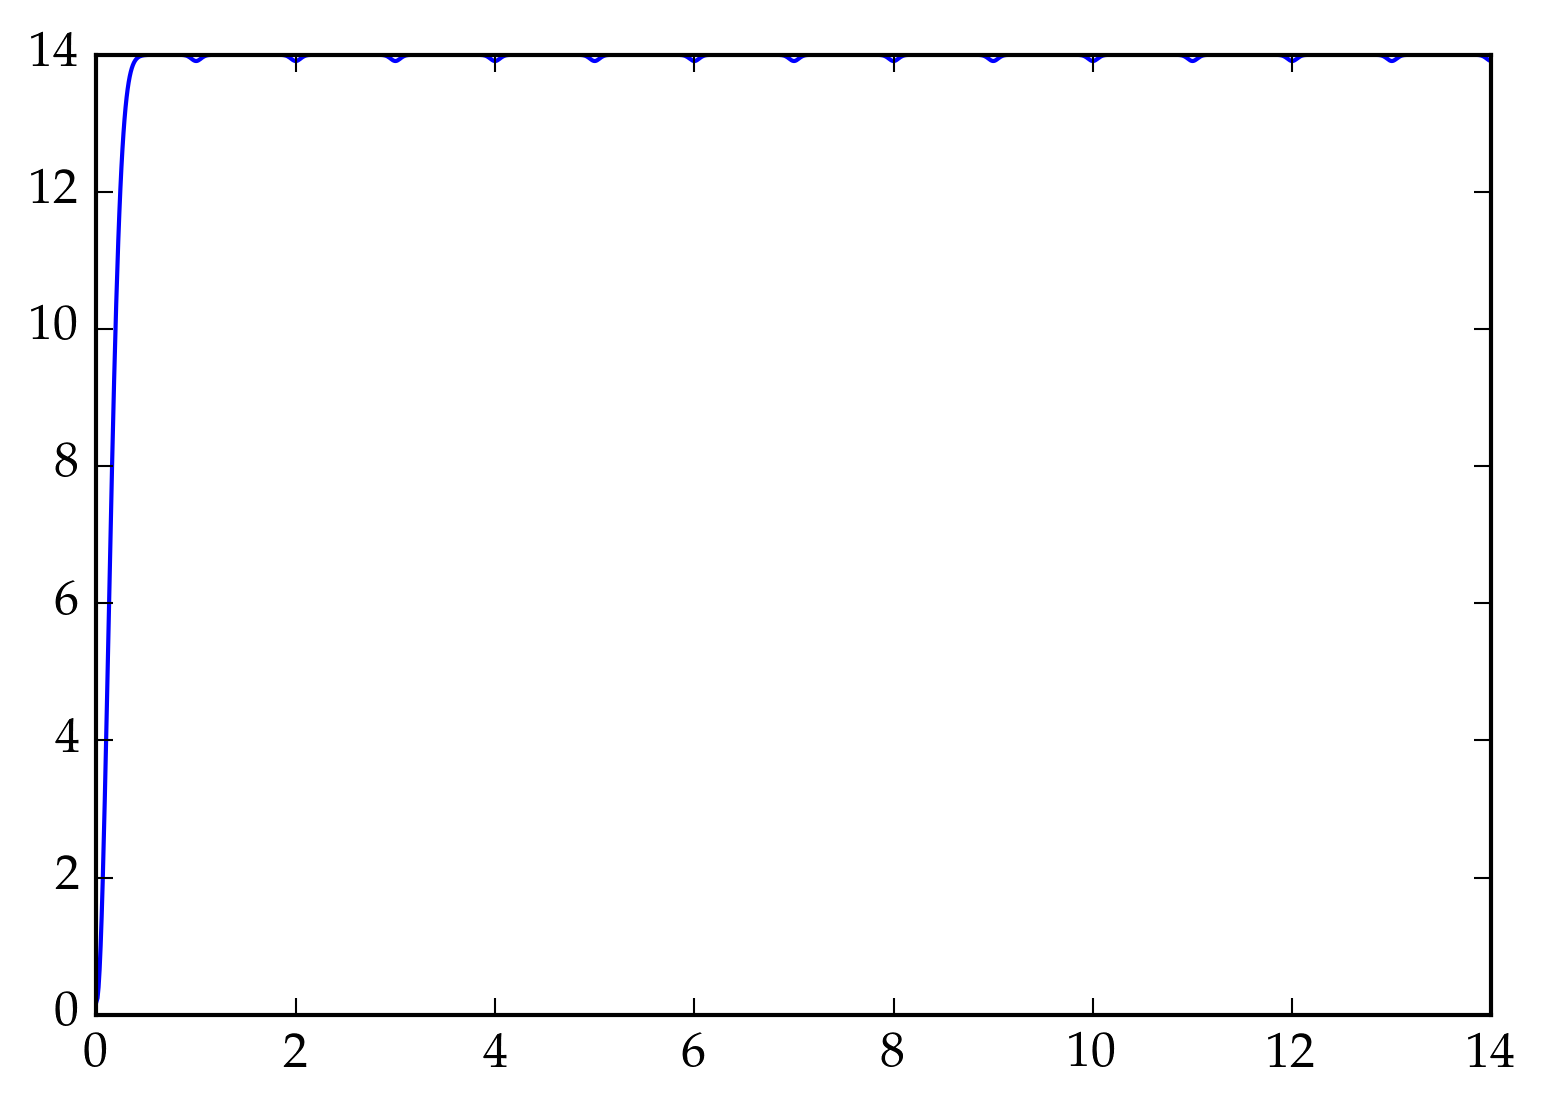

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3211dc410>

In [25]:
rr = linspace(0.0, 24*14, 24*14*4)
ck_r = [cov(reals.k, [0.0,0.0,0.0], [r,0.0,0.0]) for r in rr]
plt.plot(rr/24.0, exp(2.0*reals.logNoise)+ck_r[1].-ck_r, label="fitted variogram")

## Refitting with Conjugate Gradient Descent

In [22]:
k_periodic = fix(Periodic(log(5.0), -2.0, log(24.0)), :lp)
k_diurndecay = fix(SEIso(log(10^5), 0.0), :lσ)

Type: GaussianProcesses.FixedKern, Params: [11.5129]


In [23]:
k_spatiotemporal_3 = Masked(k_time, [1]) * Masked(k_spatial, [2,3]) + 
    fix(Masked(k_means, [2,3])) +
    Masked(k_periodic, [1]) * Masked(k_diurndecay, [2,3])

Type: GaussianProcesses.SumKernel
  Type: GaussianProcesses.ProdKernel
    Type: GaussianProcesses.Masked{GaussianProcesses.SEIso}, Params: [0.996834,1.3172]
    Type: GaussianProcesses.Masked{GaussianProcesses.FixedKern}, Params: [12.0805]
  Type: GaussianProcesses.FixedKern, Params: Float64[]
  Type: GaussianProcesses.ProdKernel
    Type: GaussianProcesses.Masked{GaussianProcesses.FixedKern}, Params: [1.60944,-2.0]
    Type: GaussianProcesses.Masked{GaussianProcesses.FixedKern}, Params: [11.5129]


In [36]:
set_params!(k_spatiotemporal_3, [1.07024,1.30932,12.0899,-1.19804,-1.20352,11.0696])

In [31]:
begin
    global opt_out
    k_spatiotemporal = k_spatiotemporal_3
    chunks=GP[]
    chunk_width=24*10
    tstart=0.0
    tend=tstart+chunk_width
    nobsv=0
    while tstart < get(maximum(hourly_cat[:ts_hours]))
        in_chunk=(tstart .<= hourly_cat[:ts_hours].values) & (hourly_cat[:ts_hours].values .< tend)
        hourly_chunk = hourly_cat[in_chunk,:]
        nobsv_chunk = sum(in_chunk)
        nobsv += nobsv_chunk

        chunk_X_PRJ = isdSubset[:X_PRJ].values[hourly_chunk[:station].values]
        chunk_Y_PRJ = isdSubset[:Y_PRJ].values[hourly_chunk[:station].values]
        chunk_X = [hourly_chunk[:ts_hours].values chunk_X_PRJ chunk_Y_PRJ]

        y = hourly_chunk[:temp].values
        chunk = GP(chunk_X', y, MeanConst(mean(y)), k_spatiotemporal, -1.0)
        push!(chunks, chunk)

        tstart=tend
        tend+=chunk_width
    end
    reals = TempModel.GPRealisations(chunks)
    update_mll_and_dmll!(reals, mean=false)
    println(reals.dmLL)
    @time opt_out=optimize!(reals, method=ConjugateGradient(), mean=false, show_trace=true, x_tol=1e-4, f_tol=1e-10)
end

[12348.3,-5395.96,1155.42,-1332.51,-392.042,156.151,-23.2588]
Iter     Function value   Gradient norm 
     0     5.585363e+04     1.234833e+04
     1     5.494010e+04     2.402008e+03
     2     5.487282e+04     1.098334e+03
     3     5.485483e+04     1.414974e+02
     4     5.485438e+04     9.617669e+01
     5     5.485416e+04     4.575807e+01
     6     5.485409e+04     2.872120e+01
     7     5.485406e+04     1.982919e+01
     8     5.485404e+04     1.129499e+01
     9     5.485404e+04     5.069390e+00
    10     5.485404e+04     4.385188e+00
    11     5.485404e+04     6.531113e+00
    12     5.485404e+04     3.594263e+00
    13     5.485404e+04     1.489070e+00
    14     5.485404e+04     1.201956e+00
756.880070 seconds (13.52 M allocations: 144.581 GB, 3.05% gc time)


Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [-1.0,1.070287594109616, ...]
 * Minimizer: [-0.8298614275021883,1.0702354141216777, ...]
 * Minimum: 5.485404e+04
 * Iterations: 14
 * Convergence: true
   * |x - x'| < 1.0e-04: true
   * |f(x) - f(x')| / |f(x)| < 1.0e-10: false
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 50
 * Gradient Calls: 35

In [34]:
print(Optim.minimizer(opt_out))

[-0.829861,1.07024,1.30932,12.0899,-1.19804,-1.20352,11.0696]

In [39]:
print("\nk: Temporal kernel \n=================\n")
@printf("σ: %5.3f\n", √k_time.σ2)
@printf("l: %5.3f hours\n", √k_time.ℓ2)
print("\nk: Spatial kernel \n=================\n")
@printf("σ: %5.3f\n", √k_spatial.kern.σ2)
@printf("l: %5.3f meters\n", √k_spatial.kern.ℓ2)
print("\nk: Periodic kernel \n=================\n")
@printf("σ: %5.3f\n", √k_periodic.kern.σ2)
@printf("l: %5.3f hours\n", √k_periodic.kern.ℓ2)
print("\nk: Periodic decay \n=================\n")
@printf("σ: %5.3f (constrained to 1)\n", √k_diurndecay.kern.σ2)
@printf("l: %5.3f meters\n", √k_diurndecay.kern.ℓ2)
print("\n=================\n")
@printf("σy: %5.3f\n", exp(reals.logNoise))


k: Temporal kernel 
σ: 3.704
l: 2.916 hours

k: Spatial kernel 
σ: 1.000
l: 178064.300 meters

k: Periodic kernel 
σ: 0.300
l: 0.302 hours

k: Periodic decay 
σ: 1.000 (constrained to 1)
l: 64189.826 meters

σy: 0.436


## Using NLopt

In [35]:
import NLopt
import NLopt: Opt, lower_bounds!, upper_bounds!, min_objective!, xtol_rel!, ftol_rel!

In [47]:
function optimize_NLopt(gpr::TempModel.GPRealisations; noise::Bool=true, mean::Bool=true, kern::Bool=true,
                    method=:LD_BFGS, x_tol=1e-4, f_tol=1e-10, show_trace=false)
    target = get_optim_target(gpr, noise=noise, mean=mean, kern=kern)
    init_x = get_params(gpr;  noise=noise, mean=mean, kern=kern)  # Initial hyperparameter values
    count = 0
    best_x = copy(init_x)
    best_y = Inf
    function myfunc(x::Vector, grad::Vector)
        count += 1
        local y::Float64
        if length(grad) > 0
            y=target.fg!(x, grad)
        else
            y = target.f(x)
        end
        if y < best_y
            best_y = y
            best_x[:] = x
            if show_trace
                @printf("Y=%.5f after %d calls at x=%s\n", best_y, count, best_x)
            end
        end
        return y
    end

    nparams = length(init_x)
    opt = Opt(method, nparams)

    lower = Array(Float64, nparams)
    upper = Array(Float64, nparams)
    lower = init_x - 3.0
    upper = init_x + 3.0
    lower_bounds!(opt, lower)
    upper_bounds!(opt, upper)
    xtol_rel!(opt, x_tol)
    ftol_rel!(opt, f_tol)
    min_objective!(opt, myfunc)
    (minf,minx,ret) = NLopt.optimize(opt, init_x)
    return minf,minx,ret,count
end

optimize_NLopt (generic function with 1 method)

In [51]:
begin
    k_spatiotemporal = k_spatiotemporal_2
    chunks=GP[]
    chunk_width=24*10
    tstart=0.0
    tend=tstart+chunk_width
    nobsv=0
    while tstart < get(maximum(hourly_cat[:ts_hours]))
        in_chunk=(tstart .<= hourly_cat[:ts_hours].values) & (hourly_cat[:ts_hours].values .< tend)
        hourly_chunk = hourly_cat[in_chunk,:]
        nobsv_chunk = sum(in_chunk)
        nobsv += nobsv_chunk

        chunk_X_PRJ = isdSubset[:X_PRJ].values[hourly_chunk[:station].values]
        chunk_Y_PRJ = isdSubset[:Y_PRJ].values[hourly_chunk[:station].values]
        chunk_X = [hourly_chunk[:ts_hours].values chunk_X_PRJ chunk_Y_PRJ]

        y = hourly_chunk[:temp].values
        chunk = GP(chunk_X', y, MeanConst(mean(y)), k_spatiotemporal, -1.0)
        push!(chunks, chunk)

        tstart=tend
        tend+=chunk_width
    end
    reals = TempModel.GPRealisations(chunks)
    update_mll_and_dmll!(reals, mean=false)

    @time opt_out=optimize_NLopt(reals, method=:LD_LBFGS, mean=false, 
        x_tol=1e-4, 
        f_tol=1e-10, 
        show_trace=true)
end        

Y=55829.71955 after 1 calls at x=[-1.0,1.06259,1.30893,12.0926,-1.2786,-1.32196,9.87868]
Y=54938.30610 after 4 calls at x=[-0.870708,1.00593,1.32112,12.0785,-1.28254,-1.32019,9.87868]
Y=54910.49538 after 5 calls at x=[-0.860946,1.02001,1.31458,12.0819,-1.2827,-1.32067,9.87868]
Y=54879.24742 after 6 calls at x=[-0.834826,1.05957,1.30331,12.0883,-1.28272,-1.32227,9.87868]
Y=54879.07954 after 7 calls at x=[-0.8338,1.06167,1.30524,12.0893,-1.28239,-1.32249,9.87868]
Y=54878.97974 after 8 calls at x=[-0.833241,1.06284,1.3082,12.0918,-1.28165,-1.32287,9.87868]
Y=54878.96913 after 9 calls at x=[-0.833335,1.06261,1.30898,12.0927,-1.28093,-1.32321,9.87869]
Y=54878.96792 after 10 calls at x=[-0.833361,1.06256,1.30909,12.0927,-1.28052,-1.32337,9.87869]
Y=54878.96701 after 11 calls at x=[-0.833348,1.06252,1.30903,12.0927,-1.27989,-1.32357,9.8787]
Y=54878.96680 after 12 calls at x=[-0.833336,1.06257,1.30901,12.0925,-1.27958,-1.32344,9.8787]
Y=54878.96664 after 13 calls at x=[-0.833324,1.06257,1.3089

(54878.96600198585,[-0.833303,1.06259,1.30892,12.0926,-1.27859,-1.32195,9.87876],:XTOL_REACHED,18)

In [50]:
@time opt_out=optimize_NLopt(reals, method=:LD_LBFGS, mean=false, 
    x_tol=1e-4, 
    f_tol=1e-20, 
    show_trace=true)

Y=54878.96600 after 1 calls at x=[-0.833303,1.06259,1.30892,12.0926,-1.27859,-1.32196,9.87865]
Y=54878.96600 after 4 calls at x=[-0.833302,1.06259,1.30893,12.0926,-1.27859,-1.32196,9.87867]
Y=54878.96600 after 5 calls at x=[-0.833303,1.06259,1.30893,12.0926,-1.2786,-1.32196,9.87868]
 99.472238 seconds (631.08 M allocations: 24.312 GB, 6.44% gc time)


(54878.96600391299,[-0.833303,1.06259,1.30893,12.0926,-1.2786,-1.32196,9.87868],:XTOL_REACHED,5)

## LD_MMA

In [52]:
k_periodic = fix(Periodic(log(5.0), -2.0, log(24.0)), :lp)
k_diurndecay = fix(SEIso(log(10^5), 0.0), :lσ)

Type: GaussianProcesses.FixedKern, Params: [11.5129]


In [53]:
k_spatiotemporal_5 = Masked(k_time, [1]) * Masked(k_spatial, [2,3]) + 
    fix(Masked(k_means, [2,3])) +
    Masked(k_periodic, [1]) * Masked(k_diurndecay, [2,3])

Type: GaussianProcesses.SumKernel
  Type: GaussianProcesses.ProdKernel
    Type: GaussianProcesses.Masked{GaussianProcesses.SEIso}, Params: [1.06259,1.30892]
    Type: GaussianProcesses.Masked{GaussianProcesses.FixedKern}, Params: [12.0926]
  Type: GaussianProcesses.FixedKern, Params: Float64[]
  Type: GaussianProcesses.ProdKernel
    Type: GaussianProcesses.Masked{GaussianProcesses.FixedKern}, Params: [1.60944,-2.0]
    Type: GaussianProcesses.Masked{GaussianProcesses.FixedKern}, Params: [11.5129]


In [54]:
begin
    k_spatiotemporal = k_spatiotemporal_5
    chunks=GP[]
    chunk_width=24*10
    tstart=0.0
    tend=tstart+chunk_width
    nobsv=0
    while tstart < get(maximum(hourly_cat[:ts_hours]))
        in_chunk=(tstart .<= hourly_cat[:ts_hours].values) & (hourly_cat[:ts_hours].values .< tend)
        hourly_chunk = hourly_cat[in_chunk,:]
        nobsv_chunk = sum(in_chunk)
        nobsv += nobsv_chunk

        chunk_X_PRJ = isdSubset[:X_PRJ].values[hourly_chunk[:station].values]
        chunk_Y_PRJ = isdSubset[:Y_PRJ].values[hourly_chunk[:station].values]
        chunk_X = [hourly_chunk[:ts_hours].values chunk_X_PRJ chunk_Y_PRJ]

        y = hourly_chunk[:temp].values
        chunk = GP(chunk_X', y, MeanConst(mean(y)), k_spatiotemporal, -1.0)
        push!(chunks, chunk)

        tstart=tend
        tend+=chunk_width
    end
    reals = TempModel.GPRealisations(chunks)
    update_mll_and_dmll!(reals, mean=false)

    @time opt_out=optimize_NLopt(reals, method=:LD_MMA, mean=false, 
        x_tol=1e-4, 
        f_tol=1e-10, 
        show_trace=true)
end        

Y=57315.33896 after 1 calls at x=[-1.0,1.06259,1.30892,12.0926,1.60944,-2.0,11.5129]
Y=55956.07978 after 8 calls at x=[-0.784521,0.913383,1.34632,12.0596,1.6094,-1.99996,11.5129]
Y=55658.89913 after 9 calls at x=[-0.824715,0.956217,1.33005,12.0714,1.60938,-1.99994,11.5129]
Y=55622.09476 after 11 calls at x=[-0.836619,0.976579,1.32214,12.0764,1.60936,-1.99992,11.5128]
Y=55618.06285 after 12 calls at x=[-0.82362,1.00682,1.3088,12.0825,1.609,-1.99955,11.5125]
Y=55613.90364 after 14 calls at x=[-0.818689,1.00002,1.31202,12.0807,1.60892,-1.99946,11.5124]
Y=55613.50573 after 16 calls at x=[-0.819585,0.99718,1.3149,12.0797,1.60872,-1.99927,11.5122]
Y=55613.36679 after 18 calls at x=[-0.820906,0.998176,1.31536,12.08,1.60818,-1.99871,11.5117]
Y=55613.29030 after 20 calls at x=[-0.821708,0.997261,1.31728,12.08,1.60691,-1.99741,11.5105]
Y=55613.27837 after 22 calls at x=[-0.822536,0.997229,1.31631,12.0801,1.60508,-1.99553,11.5087]
Y=55613.25870 after 23 calls at x=[-0.821978,0.997005,1.31707,12.0

(54854.03454256928,[-0.829827,1.07027,1.30937,12.09,-1.19783,-1.20323,11.0712],:XTOL_REACHED,118)

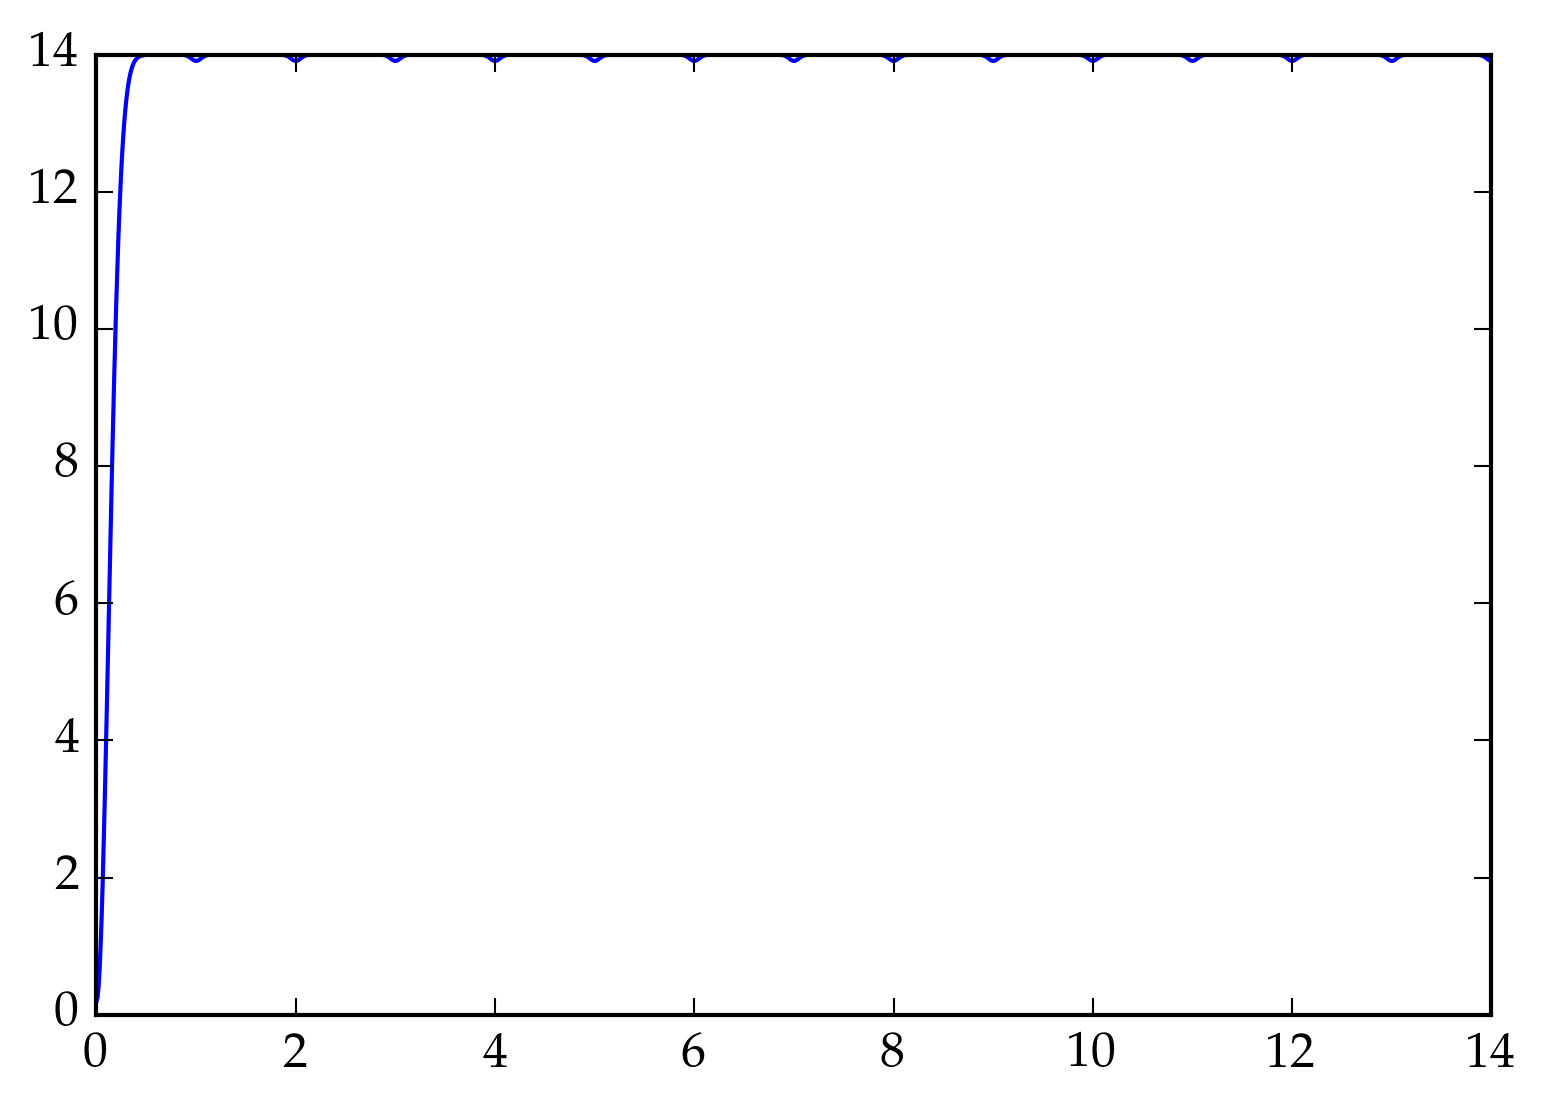

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x322c80750>

In [57]:
hyp = opt_out[2]
rr = linspace(0.0, 24*14, 24*14*4+1)
ck_r = [cov(k_spatiotemporal_5, [0.0,0.0,0.0], [r,0.0,0.0]) for r in rr]
plt.plot(rr/24.0, exp(2.0*hyp[1])+ck_r[1].-ck_r, label="fitted variogram")

# Merging diurnal component

In [68]:
k_periodic = fix(Periodic(log(1.0), -1.0, log(24.0)), :lp)

Type: GaussianProcesses.FixedKern, Params: [0.0,-1.0]


In [69]:
k_spatiotemporal_6 = Masked(k_time + k_periodic, [1]) * Masked(k_spatial, [2,3]) + 
    fix(Masked(k_means, [2,3]))

Type: GaussianProcesses.SumKernel
  Type: GaussianProcesses.ProdKernel
    Type: GaussianProcesses.Masked{GaussianProcesses.SumKernel}, Params: [0.996764,1.3169,0.0,-1.0]
    Type: GaussianProcesses.Masked{GaussianProcesses.FixedKern}, Params: [12.0803]
  Type: GaussianProcesses.FixedKern, Params: Float64[]


In [70]:
begin
    global opt_out
    k_spatiotemporal = k_spatiotemporal_6
    chunks=GP[]
    chunk_width=24*10
    tstart=0.0
    tend=tstart+chunk_width
    nobsv=0
    while tstart < get(maximum(hourly_cat[:ts_hours]))
        in_chunk=(tstart .<= hourly_cat[:ts_hours].values) & (hourly_cat[:ts_hours].values .< tend)
        hourly_chunk = hourly_cat[in_chunk,:]
        nobsv_chunk = sum(in_chunk)
        nobsv += nobsv_chunk

        chunk_X_PRJ = isdSubset[:X_PRJ].values[hourly_chunk[:station].values]
        chunk_Y_PRJ = isdSubset[:Y_PRJ].values[hourly_chunk[:station].values]
        chunk_X = [hourly_chunk[:ts_hours].values chunk_X_PRJ chunk_Y_PRJ]

        y = hourly_chunk[:temp].values
        chunk = GP(chunk_X', y, MeanConst(mean(y)), k_spatiotemporal, -1.0)
        push!(chunks, chunk)

        tstart=tend
        tend+=chunk_width
    end
    reals = TempModel.GPRealisations(chunks)
    update_mll_and_dmll!(reals, mean=false)
    println(reals.dmLL)
    @time opt_out=optimize!(reals, method=ConjugateGradient(), 
        mean=false, 
        show_trace=true, 
        x_tol=1e-4, 
        f_tol=1e-10)
end

[13039.7,-6377.62,1072.04,-87.8863,132.316,-1510.57]
Iter     Function value   Gradient norm 
     0     5.664311e+04     1.303967e+04
     1     5.570998e+04     3.594115e+03
     2     5.556901e+04     1.306949e+03
     3     5.554197e+04     2.667508e+02
     4     5.554070e+04     1.413115e+02
     5     5.553747e+04     2.246180e+02
     6     5.552231e+04     1.071390e+03
Base.LinAlg.PosDefException(165)
     7     5.503239e+04     3.303242e+03
     8     5.502410e+04     3.181339e+03
     9     5.484744e+04     1.630686e+03
    10     5.475881e+04     3.693840e+02
    11     5.474460e+04     5.653335e+02
    12     5.474035e+04     3.079222e+02
    13     5.473238e+04     1.875233e+02
    14     5.472493e+04     6.165645e+02
    15     5.471275e+04     5.415417e+02
    16     5.469578e+04     7.855823e+01
    17     5.469564e+04     4.785853e+01
    18     5.469554e+04     3.561604e+01
    19     5.469541e+04     3.930413e+01
    20     5.469539e+04     2.476969e+01
    21     5

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [-1.0,0.9967642229284615, ...]
 * Minimizer: [-0.8197628248470579,1.0512357347914791, ...]
 * Minimum: 5.469524e+04
 * Iterations: 33
 * Convergence: true
   * |x - x'| < 1.0e-04: true
   * |f(x) - f(x')| / |f(x)| < 1.0e-10: false
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 112
 * Gradient Calls: 78

In [71]:
print(Optim.minimizer(opt_out))

[-0.819763,1.05124,1.17443,-0.434307,0.514778,12.0078]

In [72]:
print(Optim.minimum(opt_out))

54695.23698830655

In [73]:
print("\nk: Temporal kernel \n=================\n")
@printf("σ: %5.3f\n", √k_time.σ2)
@printf("l: %5.3f hours\n", √k_time.ℓ2)
print("\nk: Spatial kernel \n=================\n")
@printf("σ: %5.3f\n", √k_spatial.kern.σ2)
@printf("l: %5.3f meters\n", √k_spatial.kern.ℓ2)
print("\nk: Periodic kernel \n=================\n")
@printf("σ: %5.3f\n", √k_periodic.kern.σ2)
@printf("l: %5.3f hours\n", √k_periodic.kern.ℓ2)
print("\n=================\n")
@printf("σy: %5.3f\n", exp(reals.logNoise))


k: Temporal kernel 
σ: 3.236
l: 2.861 hours

k: Spatial kernel 
σ: 1.000
l: 164029.503 meters

k: Periodic kernel 
σ: 1.673
l: 0.648 hours

σy: 0.441


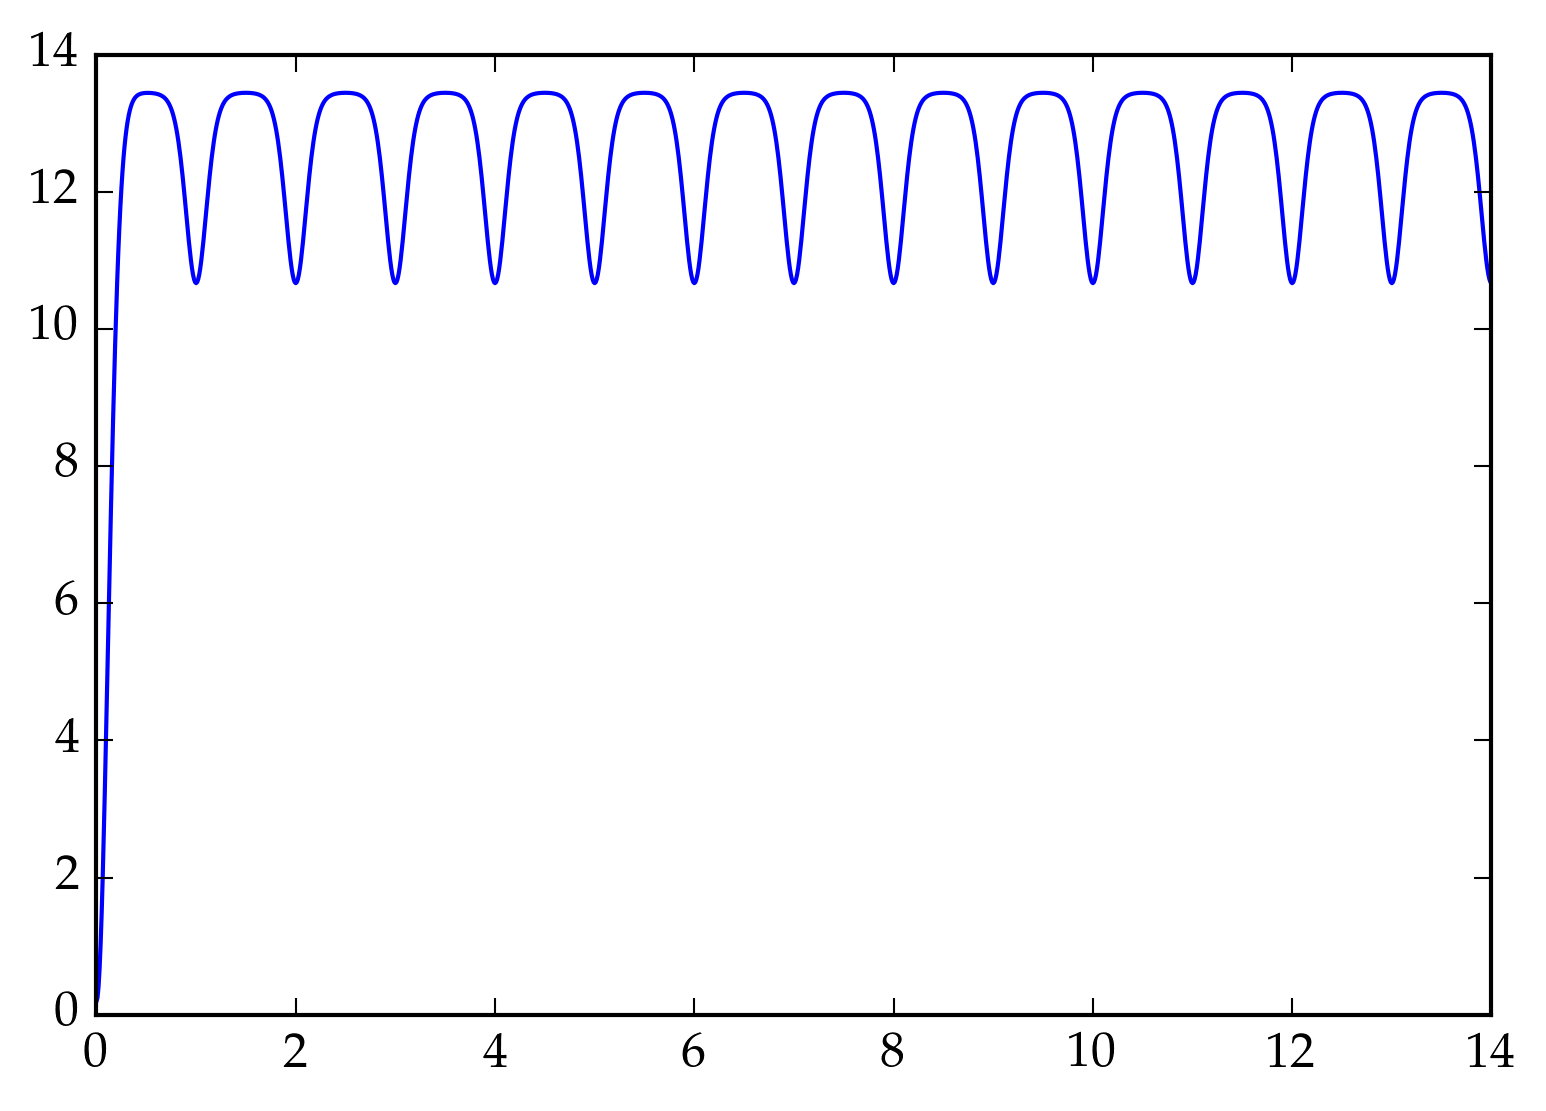

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31920f3d0>

In [74]:
hyp = Optim.minimizer(opt_out)
rr = linspace(0.0, 24*14, 24*14*4+1)
ck_r = [cov(k_spatiotemporal_6, [0.0,0.0,0.0], [r,0.0,0.0]) for r in rr]
plt.plot(rr/24.0, exp(2.0*hyp[1])+ck_r[1].-ck_r, label="fitted variogram")

## Try to get diurnal decay back in there

In [76]:
get_params(k_spatial)

1-element Array{Float64,1}:
 12.0078

In [79]:
k_periodic = fix(Periodic(log(5.0), -2.0, log(24.0)), :lp)
k_diurndecay = fix(SEIso(log(10^5), 0.0), :lσ)
k_spatiotemporal_7 = Masked(k_time, [1]) * Masked(k_spatial, [2,3]) + 
    fix(Masked(k_means, [2,3])) +
    Masked(k_periodic, [1]) * Masked(k_diurndecay, [2,3])
hyp7 = [1.05124,1.17443,12.0078,-0.434307,0.514778,12.0078]
set_params!(k_spatiotemporal_7, hyp7)

In [81]:
begin
    global opt_out
    k_spatiotemporal = k_spatiotemporal_7
    chunks=GP[]
    chunk_width=24*10
    tstart=0.0
    tend=tstart+chunk_width
    nobsv=0
    while tstart < get(maximum(hourly_cat[:ts_hours]))
        in_chunk=(tstart .<= hourly_cat[:ts_hours].values) & (hourly_cat[:ts_hours].values .< tend)
        hourly_chunk = hourly_cat[in_chunk,:]
        nobsv_chunk = sum(in_chunk)
        nobsv += nobsv_chunk

        chunk_X_PRJ = isdSubset[:X_PRJ].values[hourly_chunk[:station].values]
        chunk_Y_PRJ = isdSubset[:Y_PRJ].values[hourly_chunk[:station].values]
        chunk_X = [hourly_chunk[:ts_hours].values chunk_X_PRJ chunk_Y_PRJ]

        y = hourly_chunk[:temp].values
        chunk = GP(chunk_X', y, MeanConst(mean(y)), k_spatiotemporal, -1.0)
        push!(chunks, chunk)

        tstart=tend
        tend+=chunk_width
    end
    reals = TempModel.GPRealisations(chunks)
    update_mll_and_dmll!(reals, mean=false)
    println(reals.dmLL)
    @time opt_out=optimize!(reals, method=ConjugateGradient(), 
        mean=false, 
        show_trace=true, 
        x_tol=1e-4, 
        f_tol=1e-10)
end

[13455.3,-5667.47,1229.24,-1676.54,-639.378,154.869,189.864]
Iter     Function value   Gradient norm 
     0     5.584447e+04     1.345534e+04
     1     5.481184e+04     2.800753e+03
     2     5.471073e+04     1.026957e+03
     3     5.468586e+04     3.087447e+02
     4     5.468195e+04     2.963383e+02
     5     5.466665e+04     5.208109e+02
     6     5.464338e+04     7.998406e+02
     7     5.459024e+04     8.893337e+02
     8     5.455531e+04     9.063317e+02
     9     5.452738e+04     6.374108e+02
    10     5.449648e+04     5.869602e+02
    11     5.448506e+04     4.123155e+02
    12     5.448264e+04     1.207996e+02
    13     5.448157e+04     1.598916e+02
    14     5.448032e+04     2.120986e+02
    15     5.447908e+04     1.255378e+02
    16     5.447840e+04     1.394887e+02
    17     5.447725e+04     1.825321e+02
    18     5.447538e+04     2.077514e+02
    19     5.447424e+04     1.561706e+02
    20     5.447342e+04     7.496725e+01
    21     5.447319e+04     5.334350e

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [-1.0,1.05124, ...]
 * Minimizer: [-0.8233695273867054,1.0277560755255644, ...]
 * Minimum: 5.447220e+04
 * Iterations: 53
 * Convergence: true
   * |x - x'| < 1.0e-04: true
   * |f(x) - f(x')| / |f(x)| < 1.0e-10: false
   * |g(x)| < 1.0e-08: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 167
 * Gradient Calls: 113

In [82]:
print(Optim.minimizer(opt_out))

[-0.82337,1.02776,1.14186,11.9454,-0.383965,0.858384,14.1618]

In [83]:
print("\nk: Temporal kernel \n=================\n")
@printf("σ: %5.3f\n", √k_time.σ2)
@printf("l: %5.3f hours\n", √k_time.ℓ2)
print("\nk: Spatial kernel \n=================\n")
@printf("σ: %5.3f\n", √k_spatial.kern.σ2)
@printf("l: %5.3f meters\n", √k_spatial.kern.ℓ2)
print("\nk: Periodic kernel \n=================\n")
@printf("σ: %5.3f\n", √k_periodic.kern.σ2)
@printf("l: %5.3f hours\n", √k_periodic.kern.ℓ2)
print("\nk: Periodic decay \n=================\n")
@printf("σ: %5.3f (constrained to 1)\n", √k_diurndecay.kern.σ2)
@printf("l: %5.3f meters\n", √k_diurndecay.kern.ℓ2)
print("\n=================\n")
@printf("σy: %5.3f\n", exp(reals.logNoise))


k: Temporal kernel 
σ: 3.133
l: 2.795 hours

k: Spatial kernel 
σ: 1.000
l: 154112.883 meters

k: Periodic kernel 
σ: 2.359
l: 0.681 hours

k: Periodic decay 
σ: 1.000 (constrained to 1)
l: 1413853.556 meters

σy: 0.439


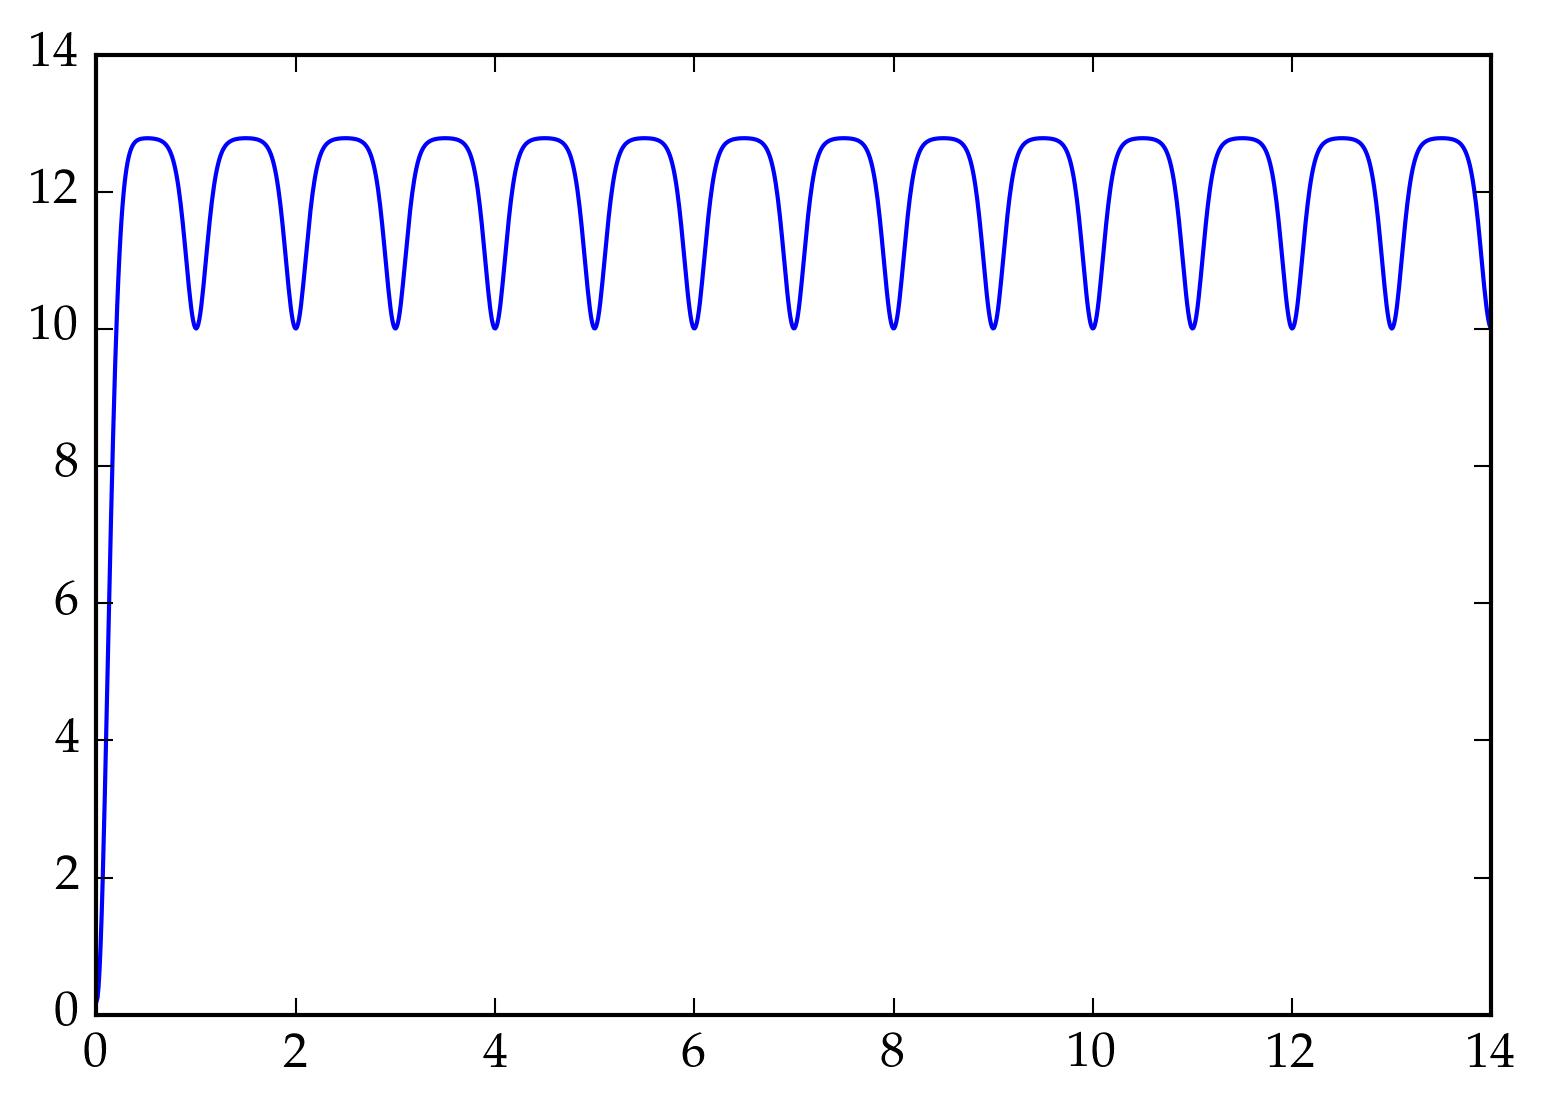

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3222b9650>

In [84]:
rr = linspace(0.0, 24*14, 24*14*4)
hyp = Optim.minimizer(opt_out)
ck_r = [cov(k_spatiotemporal_6, [0.0,0.0,0.0], [r,0.0,0.0]) for r in rr]
plt.plot(rr/24.0, exp(2.0*hyp[1])+ck_r[1].-ck_r, label="fitted variogram")